This notebook is part of the flood-detection workflow. 
    - **Import DG image downloaded from GBDX platform
    - Convert geotiff files to numpy array via rasterio
    - Scale to surface reflectance values (divide by 10,000)
    - Define individual bands for later calculations
    - Calculate indices (NDVI, multiple versions of NDWI) and dark parameter
    - Threshold and plot based on Cloud to Street algorithm
    - Calculate MSI and MBI
    - Threshold and plot NDVI, NDWI and MSI**
    - Compare output to Cloud-to-Street results
    - Validate output based on reference data
    - Explore outputs from supervised and unsupervised learning modules. 
    
Bolded items are completed within this notebook. 

List of acronyms:
NDWI : Normalized difference water index
NDVI : Normalized difference vegetation index
MSI : Morphological shadow index
MBI : Morphological building index

This notebook calculates and plots NDVI, a "dark" parameter (defined below) and several formulations of NDWI as defined within the notebook. Cloud and flood plots are produced in part based on the algorithm provided by Cloud to Street:

**Final algorithm from Cloud-to-Street for Abidjan image:**

**Clouds:** C ≥ 0.25 and RE  ≥ 0.25

**Flood:**

(NDWI1 ≥ 0.03, DARK ≤ 5, C ≤ 1, and R ≤ 0.85 ) or *check with Jeff re NDWI1 threshold. replaced with 0.03 for now

(NDWI2 ≥ 0.03, DARK ≤ 5.8, C ≤ 1)

*Note that thresholds vary slightly as this notebook was developed for pan-sharpened imagery while the original Cloud to Street algorithm was developed for non-pansharpened imagery. 

DARK = RE + NIR1 + NIR2

This notebook also calculates the MSI based on Huang et al. (2012). The calculation utilizes the scikit-image blacktop hat package. 

**References**
Huang, X., Xie, C., Fang, X., Zhang, L. (2015) Combining Pixel-and Object-Based Machine Learning for Identification of Water-Body Types from Urban High-Resolution Remote-Sensing Imagery. IEEE J. Sel. Top. Appl. Earth Obs. Remote Sens. 8, 2097–2110.

Huang, X., and Zhang, L. (2012) Morphological Building/Shadow Index for Building Extraction From High-Resolution
Imagery Over Urban Areas. IEEE J. Sel. Top. Appl. Earth Obs. Remote Sens. 5, 161-172.

Xie, C., Huang, X., Zeng, W., & Fang, X. (2016). A novel water index for urban high-resolution eight-band WorldView-2 imagery. International Journal of Digital Earth, 9(10), 925–941.

Cloud to Street. Urban Flood Mapping Using Very-High Resolution Satellite Imagery. Available at: https://abidjan.cloudtostreet.info/info

In [1]:
%matplotlib inline

In [2]:
# Import necessary packages
import os
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from glob import glob
import rasterio as rio
from rasterio.mask import mask
import earthpy as et
import earthpy.spatial as es

# Import modules with custom functions
import calc_array_mask
import morph_indices

In [3]:
# Set working directory
os.chdir(os.path.join(et.io.HOME, 'earth-analytics','spring-2019', 'flood-detection'))
os.environ["PROJ_LIB"] = r"C:\Users\katy\Anaconda3\envs\earth-analytics-python\Library\share"

### Note: update "aoi" parameter and band_path with directory name for imagery of interest

In [4]:
# Identify area of interest (aoi), set directories for inputs and outputs
aoi = "koumassi_focus_ps"

band_path = os.path.join("dg-data", aoi +"\\")
all_dg_bands = glob(band_path+"*band_*")
all_dg_bands.sort()

outputs_path= os.path.join(band_path, "outputs\\indices_and_mask_files\\")
try:
    os.makedirs(outputs_path)
except FileExistsError:
    print("Directory already exists!")
# outputs_path = os.path.join(band_path, "outputs\\")

Directory already exists!


In [5]:
# Create raster stack of all bands
all_bands_path = os.path.join(outputs_path, aoi + "_all_bands.tif")
all_bands, all_bands_meta = es.stack(all_dg_bands,
                                             all_bands_path)

In [6]:
# Open raster stack and make copies of meta file for use in writing out files later
with rio.open(all_bands_path) as src:
    all_bands_stack = src.read()
    stack_meta = src.meta
    files_out_meta = src.meta.copy()
    masks_out_meta = src.meta.copy()
    stack_out_meta = src.meta.copy()

In [7]:
# Update files_out_meta for writing out single files
files_out_meta['count']=1
# _test NDVI, NDWI, MSI files saved without using 'nodata' = -9999
# files_out_meta['nodata']=-9999

# Update masks_out_meta for writing single integer type files
masks_out_meta['dtype'] = 'int32'
masks_out_meta['count'] = 1

# Update stack_out_meta for writing out cloud masked band stack
stack_out_meta['nodata']=-999999

In [8]:
# Scale raster stack to surface reflectance values (should be between 0 and 1)
all_bands_scaled = all_bands_stack/10000

In [9]:
# Plot histogram to explore scaled value distribution 
# fig,ax = plt.subplots()
# plt.hist(all_bands_scaled.ravel());

In [10]:
# Read in scaled bands
coastal_scaled = all_bands_scaled[0]
blue_scaled = all_bands_scaled[1]
green_scaled = all_bands_scaled[2]
yellow_scaled = all_bands_scaled[3]
red_scaled = all_bands_scaled[4]
rededge_scaled = all_bands_scaled[5]
nearir1_scaled = all_bands_scaled[6]
nearir2_scaled = all_bands_scaled[7]

# Calculate and apply cloud mask

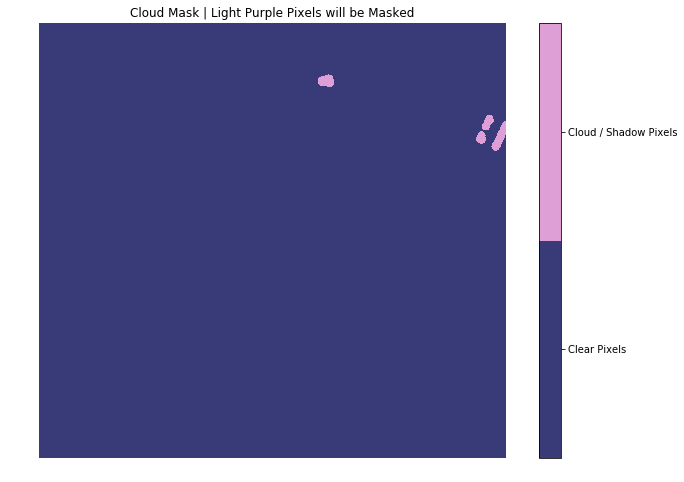

In [11]:
# Calculate and plot cloud mask
cloud_mask = calc_array_mask.define_mask(
    band1=coastal_scaled, band2=rededge_scaled, threshold1=0.25, threshold2=0.25, disk_size=15)

# Plot cloud mask
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(cloud_mask,
               cmap=plt.cm.get_cmap('tab20b', 2))
cbar = fig.colorbar(im)
cbar.set_ticks((0.25, .75))
cbar.ax.set_yticklabels(["Clear Pixels", "Cloud / Shadow Pixels"])
ax.set_title("Cloud Mask | Light Purple Pixels will be Masked")
ax.set_axis_off()
plt.show()

In [12]:
# Apply cloud mask to scaled raster stack
all_bands_cl_free = calc_array_mask.apply_mask(mask_array = cloud_mask, raster_input = all_bands_scaled)

# Write out cloud mask stack
# all_bands_cl_free_path = os.path.join(outputs_path, aoi + "_all_bands_cl_free.tif")
# all_bands_clfree, all_bands_cl_free_meta = es.stack(all_bands_cl_free,all_bands_cl_free_path)

In [13]:
with rio.open(outputs_path+'all_bands_cl_free_'+aoi+'.tif', 'w', **stack_out_meta) as dst:
    dst.write(all_bands_cl_free)

In [14]:
# Define cloud masked scaled bands
coastal_cl_free = all_bands_cl_free[0]
blue_cl_free = all_bands_cl_free[1]
green_cl_free = all_bands_cl_free[2]
yellow_cl_free = all_bands_cl_free[3]
red_cl_free = all_bands_cl_free[4]
rededge_cl_free = all_bands_cl_free[5]
nearir1_cl_free = all_bands_cl_free[6]
nearir2_cl_free = all_bands_cl_free[7]

In [15]:
# Calculated NDWI, NDVI and dark parameter for cloud masked bands
ndwi0_cl_free = es.normalized_diff(b1=green_cl_free, b2=nearir1_cl_free)  
ndwi1_cl_free = es.normalized_diff(b1=coastal_cl_free, b2=nearir2_cl_free)
ndwi2_cl_free = es.normalized_diff(b1= yellow_cl_free, b2=nearir2_cl_free)
ndvi_cl_free = es.normalized_diff(b1=nearir1_cl_free, b2= red_cl_free)
dark_cl_free = rededge_cl_free+nearir1_cl_free+nearir2_cl_free

In [16]:
# Compare mean NDWI valuespre and post cloud mask
# mean_ndwi0_cl_free = np.nanmean(ndwi0_cl_free)
# mean_ndwi1_cl_free = np.nanmean(ndwi1_cl_free)
# mean_ndwi2_cl_free = np.nanmean(ndwi2_cl_free)

# print("NDWI0_cl_free:",mean_ndwi0_cl_free, "NDWI1_cl_free:", mean_ndwi1_cl_free, "NDWI2_cl_free:", mean_ndwi2_cl_free)
# print("NDWI0:",mean_ndwi0, "NDWI1:", mean_ndwi1, "NDWI2:", mean_ndwi2)

NDWI0_cl_free: -0.09886868 NDWI1_cl_free: -0.15151338 NDWI2_cl_free: -0.024830408


NameError: name 'mean_ndwi0' is not defined

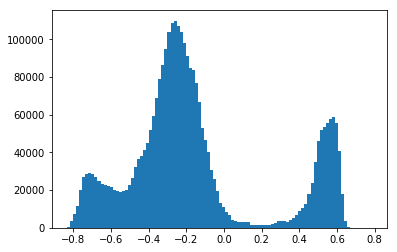

In [17]:
# Plot histogram to explore distribution of MSI values
fig,ax = plt.subplots()
plt.hist(ndwi1_cl_free.ravel(),bins=100);

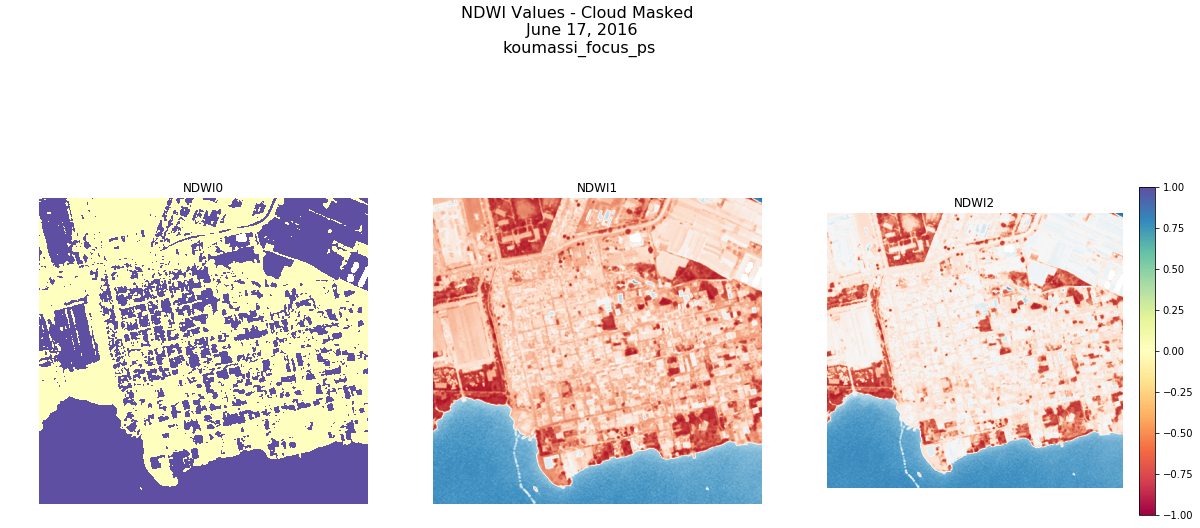

In [18]:
# Plot NDWIs for cloud masked
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

plt.suptitle('NDWI Values - Cloud Masked \n June 17, 2016\n'+aoi, fontsize=16)

ndwi0_cl_free_plot = ax1.imshow(ndwi0_cl_free>-0.1, cmap='Spectral',vmin=-1, vmax=1)
fig.colorbar(ndwi0_cl_free_plot, fraction=.05)
ax1.set(title="NDWI0")
ax1.set_axis_off()

ndwi1_cl_free_plot = ax2.imshow(ndwi1_cl_free, cmap='RdBu',vmin=-1, vmax=1)
ax2.set(title="NDWI1")
ax2.set_axis_off()
                        
ndwi2_cl_free_plot = ax3.imshow(ndwi2_cl_free, cmap='RdBu',vmin=-1, vmax=1)
ax3.set(title="NDWI2")
ax3.set_axis_off()

In [19]:
# Calculate MSI
msi = morph_indices.calc_msi(raster_input=all_bands_cl_free, s_min=2, s_max=52, s_delta = 5)
# print(msi.max())

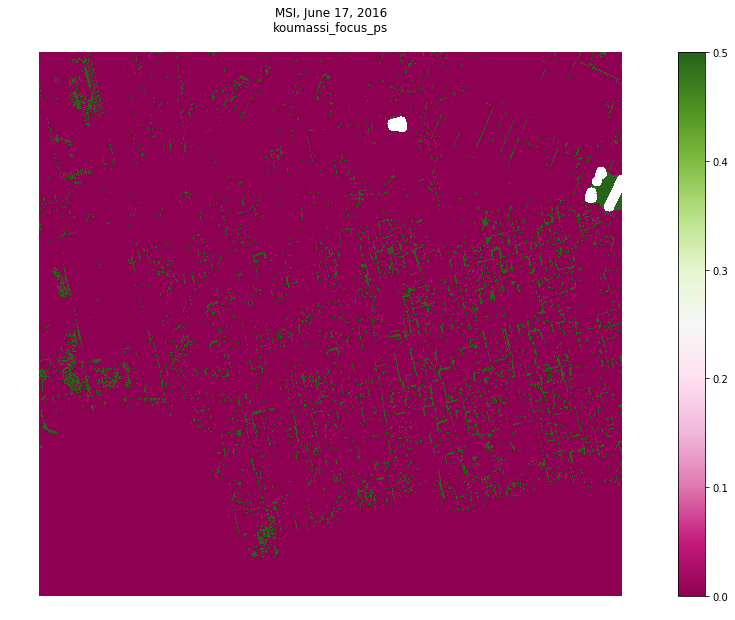

In [20]:
# Plot MSI
fig, ax = plt.subplots(figsize=(20,10))
msi_plot = ax.imshow(msi>=0.12, cmap='PiYG',
                vmin=0, vmax=0.5)
fig.colorbar(msi_plot, fraction=0.05)
ax.set(title="MSI, June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

### *Think about how to handle cloud edge effects. Large max MSI indicates a potential issue*

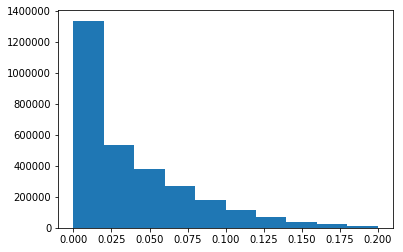

In [21]:
# # Plot histogram to explore distribution of MSI values
fig,ax = plt.subplots()
plt.hist(msi.ravel(),bins=[0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.20]);

In [22]:
# from skimage.morphology import opening, disk
# selem_msi = disk(4)
# smoothed_msi = opening(msi, selem_msi)

# # Plot shadow mask 
# fig, ax = plt.subplots(figsize=(20,10))
# test_plot = ax.imshow(smoothed_msi, cmap='PiYG',
#                 vmin=0, vmax=0.1)
# fig.colorbar(test_plot, fraction=.05)
# ax.set(title="Smoothed MSI, June 17, 2016\n"+aoi+"\n")
# ax.set_axis_off()
# plt.show()

Note: changed MSI parameters from regular workflow. 

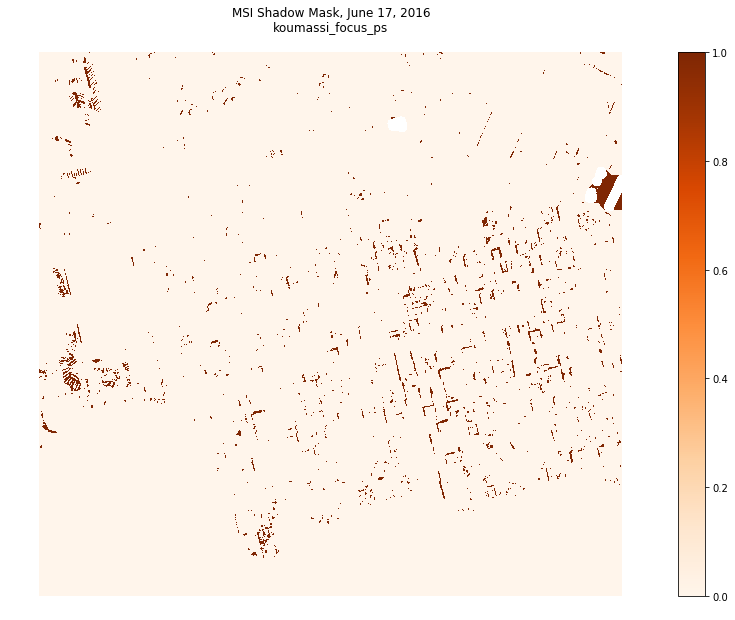

In [23]:
# Develop shadow mask from MSI
shadow_mask = morph_indices.smooth_disk(index_array=msi,threshold=0.14,disk_size=1)

# Plot shadow mask 
fig, ax = plt.subplots(figsize=(20,10))
test_plot = ax.imshow(shadow_mask, cmap='Oranges',
                vmin=0, vmax=1)
fig.colorbar(test_plot, fraction=.05)
ax.set(title="MSI Shadow Mask, June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

In [24]:
all_bands_shadow_free = calc_array_mask.apply_mask(mask_array = shadow_mask, raster_input = all_bands_scaled)

In [25]:
#Write out shadow masked stack
print(all_bands_shadow_free.shape)
print(stack_out_meta)
with rio.open(outputs_path+'shadow_masked_stack_test.tif', 'w', **stack_meta) as dst:
    dst.write(all_bands_shadow_free)

(8, 1668, 1788)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -999999, 'width': 1788, 'height': 1668, 'count': 8, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(4.7161336687028385e-06, 0.0, -3.9540278592885376,
       0.0, -4.7161336687028385e-06, 5.28788514646784)}


## When this is imported into ArcGIS, the mask does not appear - why?

In [26]:
from sklearn.cluster import KMeans
from scipy.ndimage import generic_filter

# Define classifier
nclass = 8
clf_kmeans = KMeans(n_clusters=nclass, random_state=10)

In [28]:
# Reshape array 
shadow_bands_im = np.rollaxis(all_bands_shadow_free, 0, 3)
X_shadow = shadow_bands_im.reshape(-1,8)# Fit the KMeans classifier to the 8-band raster stack

In [29]:
predictedClass_shadow = clf_kmeans.fit_predict(X_shadow, y=None)
# use the fit model
# predictedClass = clf_pl.predict(X_pl)
predictedClass_shadow += 1

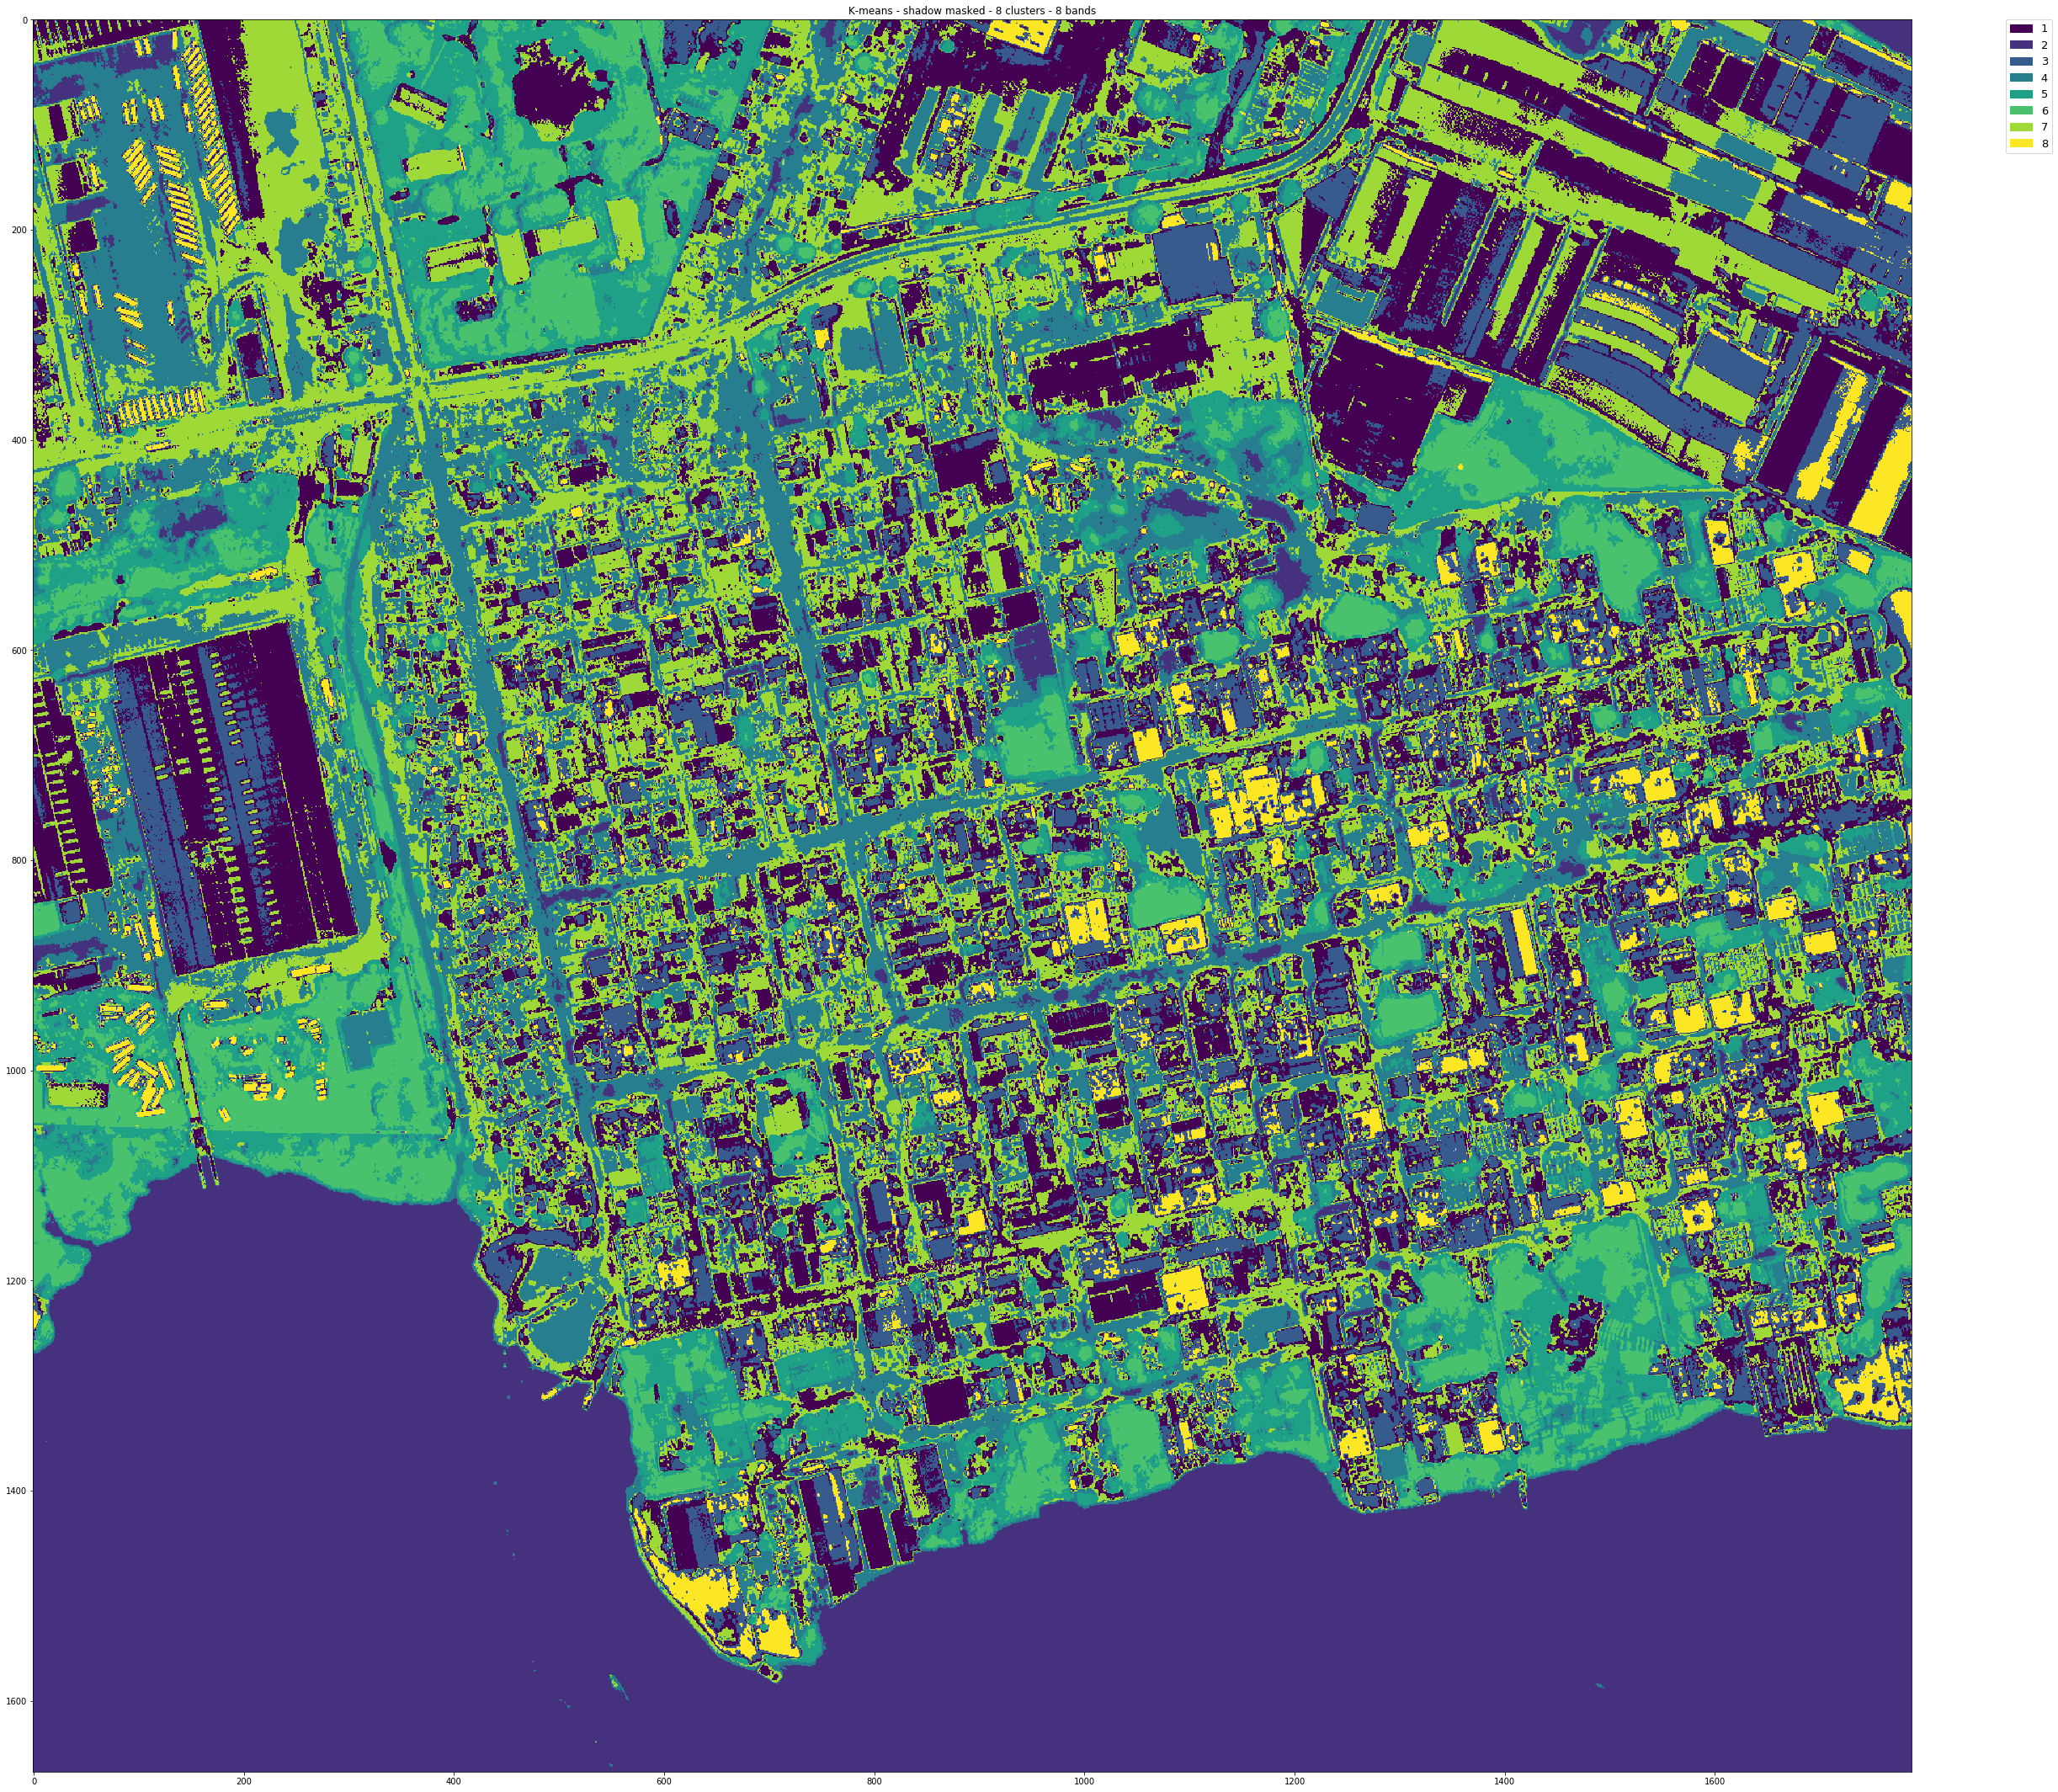

In [30]:
import earthpy.plot as ep
## Plot the result
fig, ax = plt.subplots(figsize = (40,40))
pred_data_shadow = predictedClass_shadow.reshape(shadow_bands_im.shape[:2])
im = ax.imshow(pred_data_shadow)
values = np.unique(pred_data_shadow)
cat_names = ["1","2","3","4","5","6","7","8"]
ep.draw_legend(im,titles=cat_names)
plt.title("K-means - shadow masked - 8 clusters - 8 bands")
# ax[1].imshow(all_bands_stack)
plt.show()

In [31]:
# Write out kmeans_shadow_masked result
pred_data_shadow = pred_data_shadow[np.newaxis,:]
with rio.open(outputs_path+'kmeans_shadow_masked_'+aoi+'.tif', 'w', **files_out_meta) as dst:
    dst.write(pred_data_shadow.astype('float32'))

## Note: kmeans result does not include shadow mask and instead is an exact replica of the non-shadow masked kmeans result. 

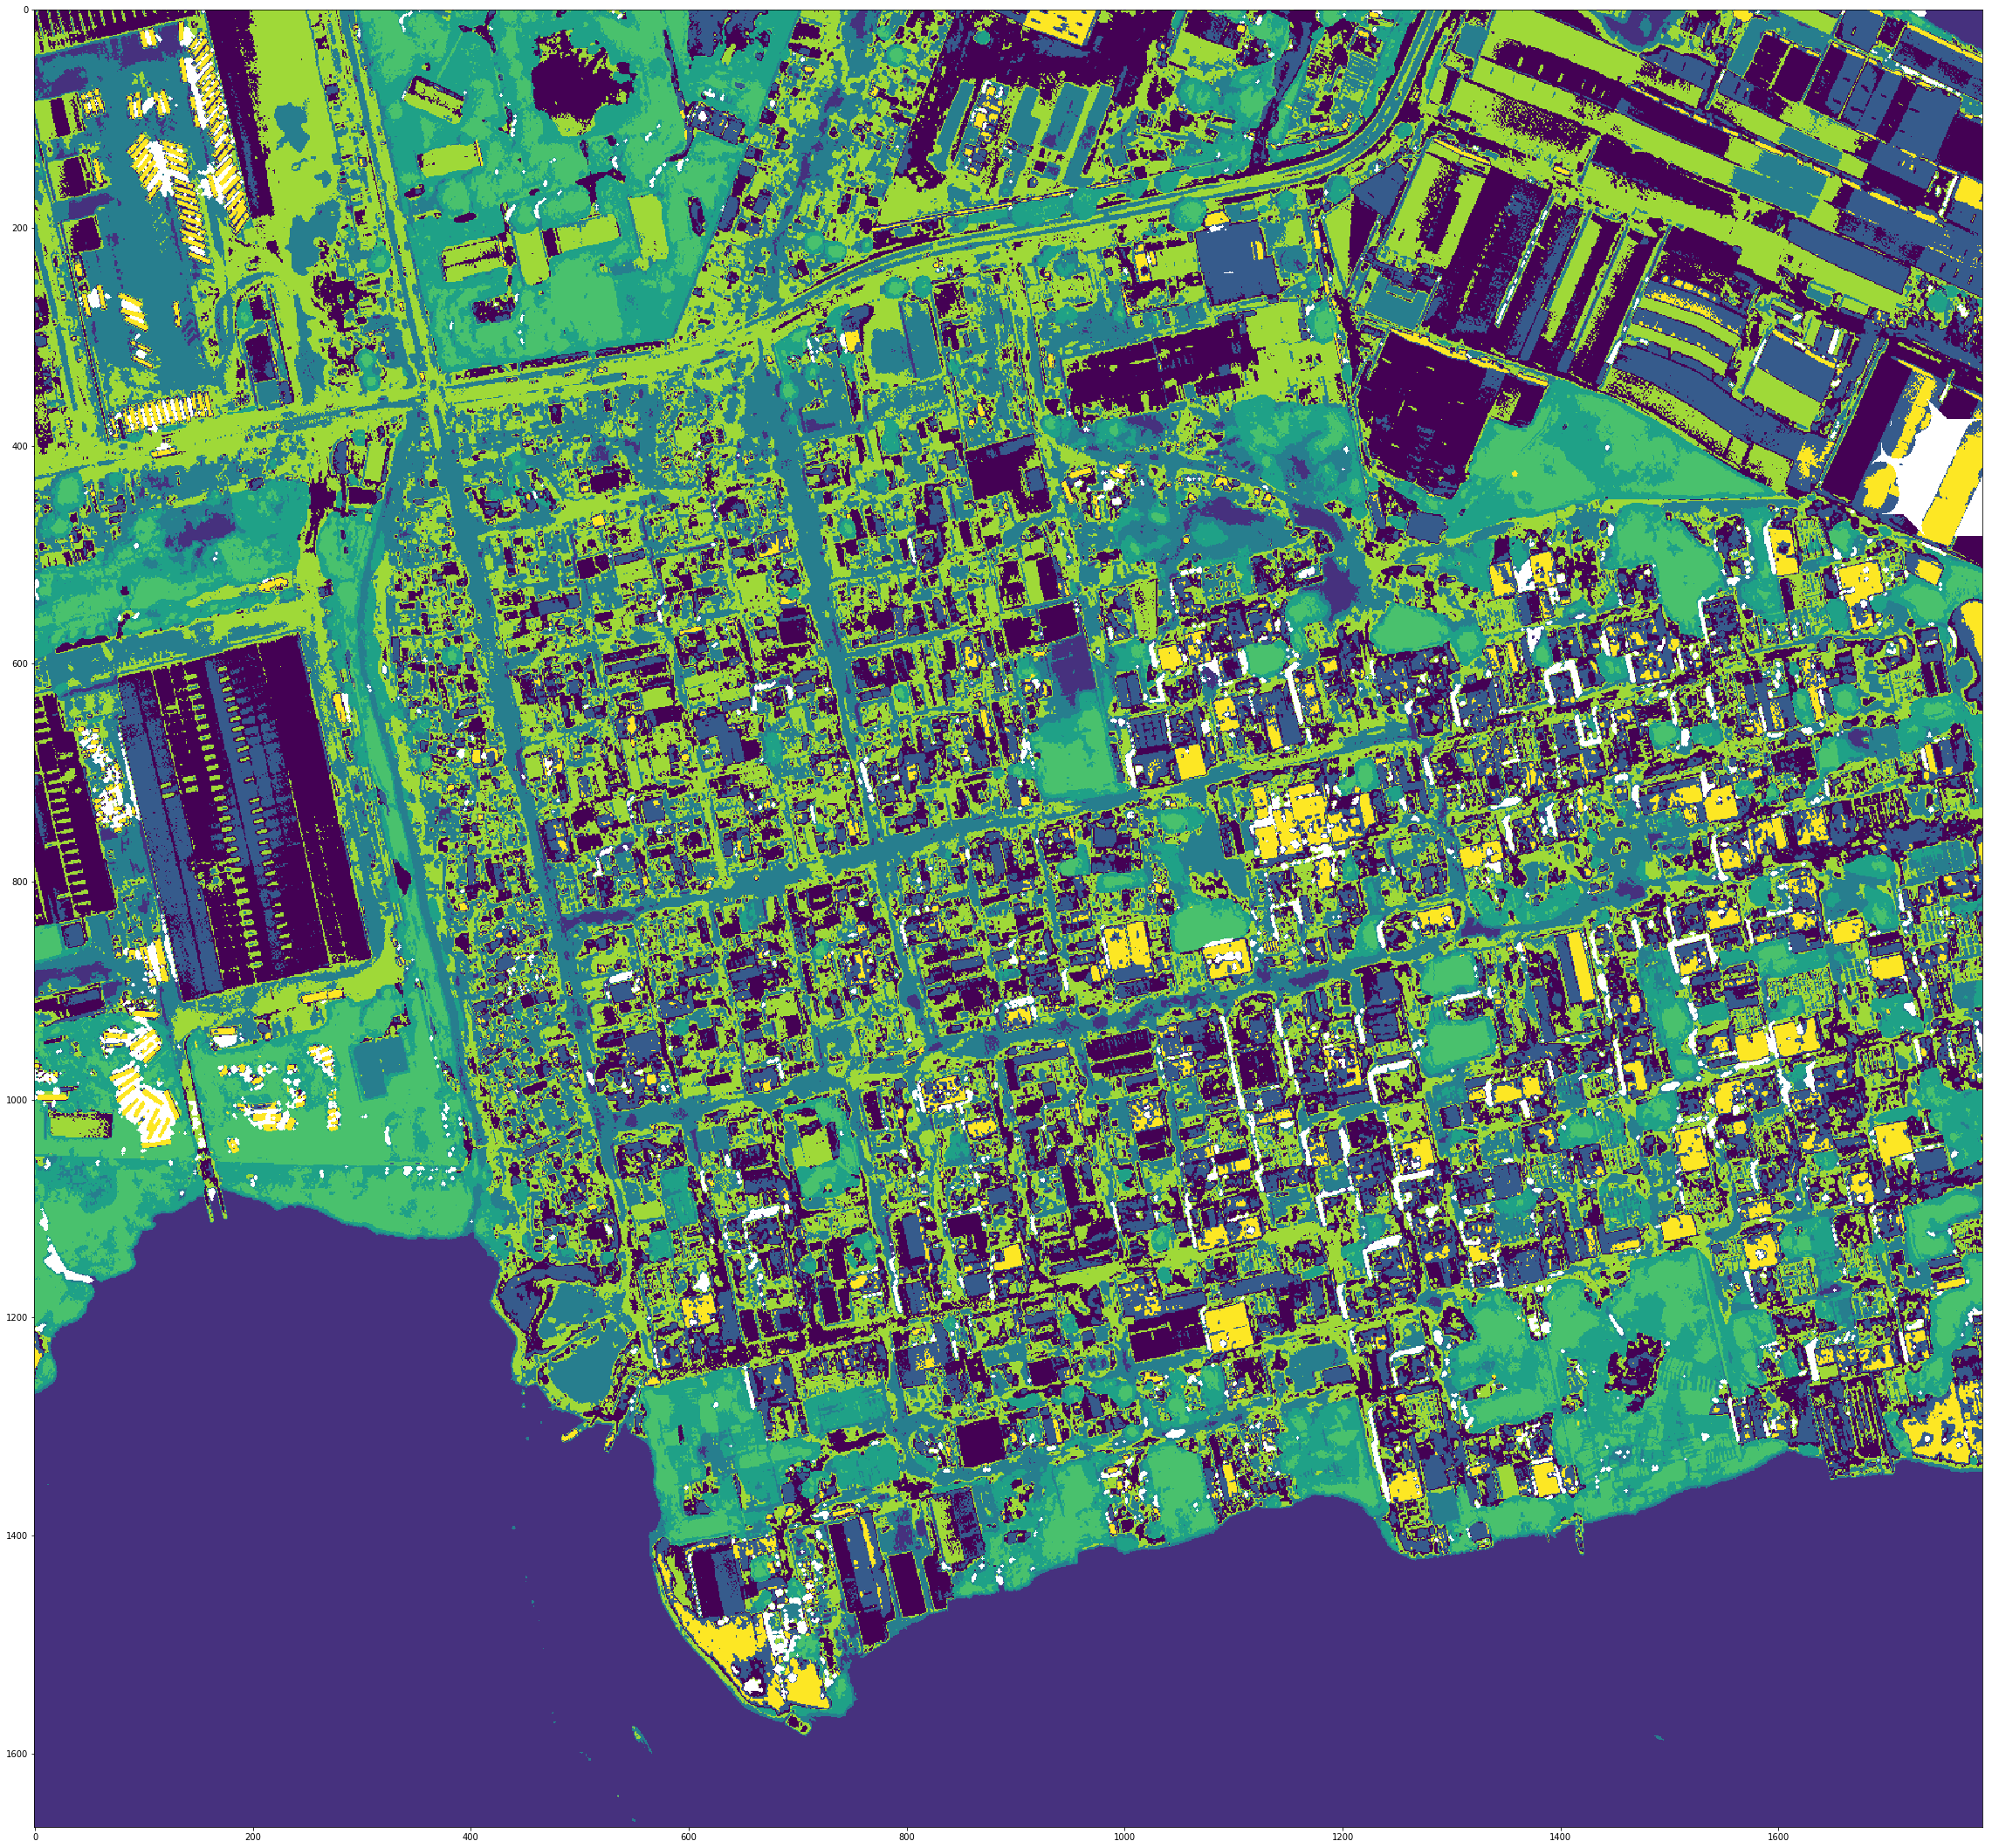

In [33]:
# Apply shadow mask to kmeans output and plot result
kmeans_shadow_free = calc_array_mask.apply_mask(mask_array = shadow_mask, raster_input = pred_data_shadow)
import earthpy.plot as ep
## Plot the result
fig, ax = plt.subplots(figsize = (40,40))
im = ax.imshow(kmeans_shadow_free[0])
# cat_names = ["1","2","3","4","5","6","7","8"]
# ep.draw_legend(im,titles=cat_names)
# plt.title("K-means - shadow masked - 8 clusters - 8 bands")
# ax[1].imshow(all_bands_stack)
plt.show()

In [ ]:
files_out_meta['nodata']=-99999
kmeans_shadow_free_out = kmeans_shadow_free[np.newaxis,:]
with rio.open(outputs_path+'kmeans_shadow_mask_applied_'+aoi+'.tif', 'w', **files_out_meta) as dst:
    dst.write(kmeans_shadow_free_out.astype('float32'))

## When I import this image into ArcGIS the mask does not appear. How do I write this out as a masked geoTIFF?